<a href="https://colab.research.google.com/github/Imartinezcuevas/k_brazos_MC_OL/blob/main/bandit_experiment_epsilon_greedy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo de algoritmos $\epsilon$-Greedy en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos epsilon-greedy en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Author: Iván Martínez Cuevas y Antonio Orenes Lucas
    Email: ivan.martinezc@um.es y antonio.orenesl@um.es
    Date: 2025/02/12

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html

# Introducción
En este experimento, exploramos el uso del algoritmo $\epsilon$-Greedy para resolver el problema del bandido de k-brazos. Este enfoque es ampliamente utilizado en el aprendizaje por refuerzo debido a su simplicidad y eficacia en la toma de decisiones secuenciales.

El algoritmo $\epsilon$-Greedy equilibrá dos funcionalidades fundamentales:

* Exploración: Con una probabilidad $\epsilon$, el agente selecciona un brazo aleatorio para descubrir nuevas opciones y mejorar sus estimaciones de recompensa.

* Explotación: Con una probabilidad 1 - $\epsilon$, el agente elige el brazo con la mayor recompensa promedio observada hasta el momento, maximizando su retorno a corto plazo.

El parámetro $\epsilon$ controla el balance entre estas dos estrategias. Un valor alto fomenta la exploración, mientras que un valor bajo prioriza la explotación.

Nuestro objetivo principal es comparar el rendimiento del algoritmo variando el valor de $\epsilon$. Los valores utilizados seran $\epsilon$ = 0, 0.01 y 0.1. Se evaluará el impacto que ocasiona variar este valor en la eficiencia del aprendizaje y la acumulación de recompensas en el tiempo.

## Preparación del entorno


In [ ]:
#@title Copiar el repositorio.

!git clone https://github.com/Imartinezcuevas/k_brazos_MC_OL.git
!cd k_brazos_MC_OL/

fatal: destination path 'k_brazos_MC_OL' already exists and is not an empty directory.


In [ ]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_MC_OL/src')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm, EpsilonGreedy
from arms import ArmNormal, Bandit, ArmBernoulli, ArmBinomial
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret, plot_arm_statistics


['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_MC_OL/src', '/content/k_brazos_MC_OL/src']


## Bucle experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [ ]:

def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.
    regrets = np.zeros((len(algorithms), steps))  # Matriz para almacenar el regret acumulado.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    # Para almacenar selecciones y recompensas promedio de cada brazo por algoritmo
    arm_counts = np.zeros((len(algorithms), bandit.k))  # Número de selecciones por brazo
    arm_rewards = np.zeros((len(algorithms), bandit.k))  # Suma de recompensas por brazo

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)
        # Obtener la recompensa esperada óptima.
        optimal_reward = current_bandit.get_expected_value(optimal_arm)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.
                regrets[idx, step] = optimal_reward*(step+1) - total_rewards_per_algo[idx] # Acumular el regret en la matriz regrets para el algoritmo idx en el paso step.

                #TODO: modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm",
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Registrar número de selecciones y recompensas por brazo
                arm_counts[idx, chosen_arm] += 1
                arm_rewards[idx, chosen_arm] += reward


    rewards /= runs
    regrets /= runs  # Calcular el promedio del regret acumulado
    arm_avg_rewards = np.divide(arm_rewards, arm_counts, out=np.zeros_like(arm_rewards), where=arm_counts != 0)
    # TODO: calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje

    return rewards, optimal_selections, regrets, arm_counts, arm_avg_rewards

# Análisis individual
El objetivo de este estudio es aislar y analizar la influencia de los parámetros en el rendimiento de los algoritmos $\epsilon$-Greedy. Para lograr esto, hemos decidido fijar otros parámetros relevantes del experimento, asegurando así que las variaciones en los resultados se deban exclusivamente a los cambios en los valores de $\epsilon$.

Este parámetro $\epsilon$ controla el balance entre exploración y explotación. En este notebook probaremos tres valores diferentes de $\epsilon$ (0, 0.01 y 0.1) para evaluar su impacto en la selección del brazo óptimo y recompensa acumulada.

* **Parámetros Fijos**

  * Número de brazos (k): Se establecerá en 10.
  * Distribución de recompensas: Se utilizará una distribución normal. Despues utilizaremos las distribuciones binomial y de Bernoulli.
  * Número de pasos (steps): Cada ejecución del algoritmo constará de 1000 pasos.
  * Número de ejecuciones (runs): Se realizarán 500 ejecuciones independientes del experimento.

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


### Recompensa promedio

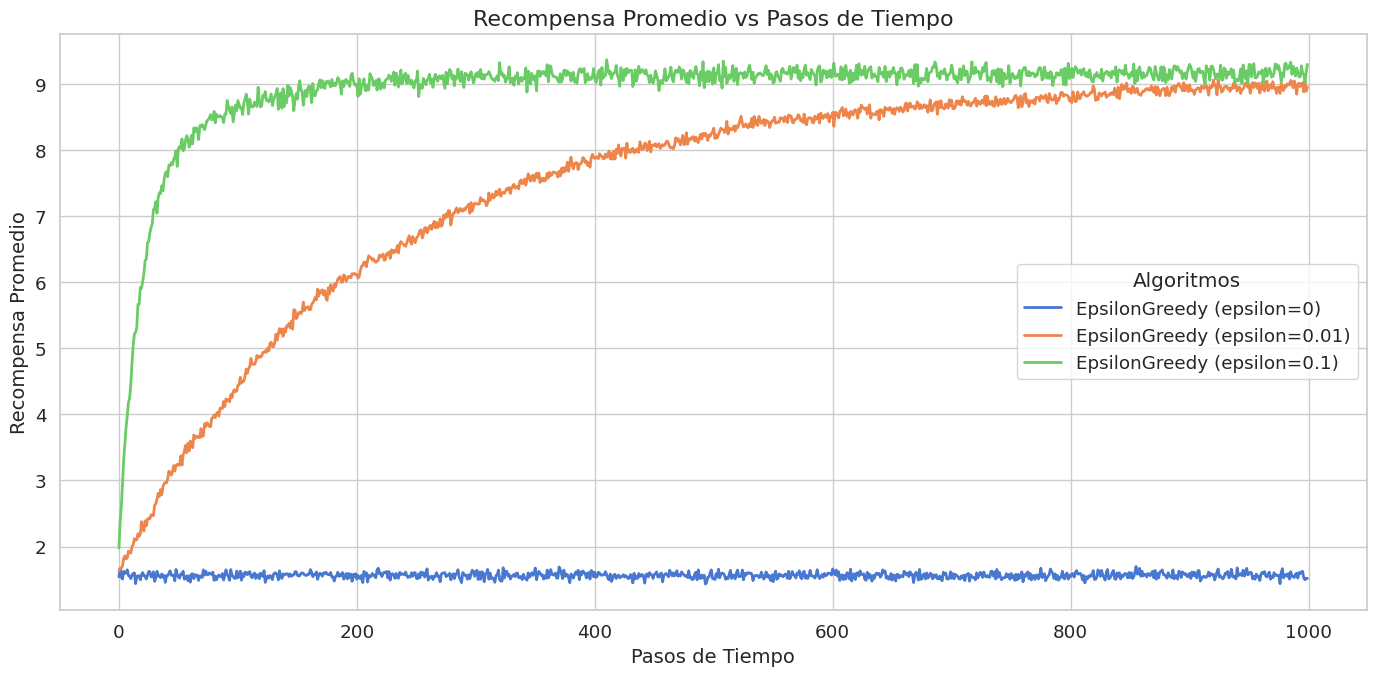

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

En el gráfico se muestra el desempeño de los diferentes valores de $\epsilon$ en los pasos de tiempo.

* Cuando $\epsilon$ tiene valor 0 se mantiene un nivel bajo de recompensa, lo que sugiere que no logra encontrar el mejor brazo, debido a la falta de exploración de nuevas opciones. Este valor de $\epsilon$ representa una estrategia completamente explotadora.

* Al asignar el valor 0.01 se puede apreciar un crecimiento lento de la recompensa. Mejora significativa respecto al valor 0. En esta ocasion, la estrategia presena una pequeña probabilidad del 1% de exploración.

* Un valor de 0.1 reseprenta un 10% de probabilidad de explorar acciones aleatorias. Con este valor se alcanza rapidamente una recompensa alta, obteniendo los mejores resultados hasta ahora.

### Regret acumulado

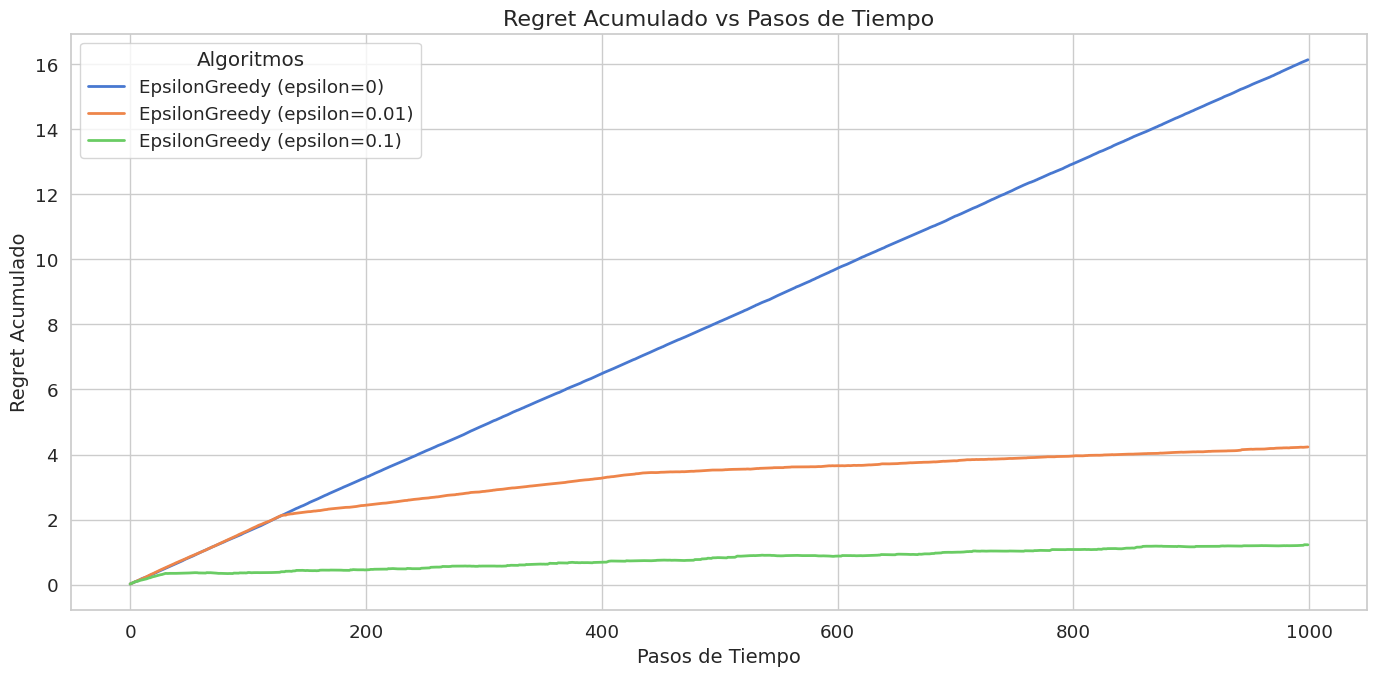

In [ ]:
plot_regret(steps, regrets, algorithms)

En el gráfico se aprecia el desempeño del algoritmo $\epsilon$-Greedy en términos de regret (remordimiento o pérdida de oportunidad) a lo largo de los pasos de tiempo. El regret mide la diferencia entre la recompensa óptima y la recompensa obtenida por el algoritmo en cada paso.

* $\epsilon$ = 0: Estrategia completamente explotadora. Su regret va creciendo linealmente a lo largo de los pasos de tiempo. Es el algoritmo que peor resultados ofrece. Esto indica que no encuentra el mejor brazo y continúa seleccionando opciones que no son óptimas.

* $\epsilon$ = 0.01: Estrategia 1% de exploración. Valor de regret crece rápido al inicio, pero se estabiliza con el paso del tiempo. Esto indica que el algoritmo no encuentra al inicio las opciones óptimas, pero según pasa los pasos de tiempo va acercándose a la solución óptima.

* $\epsilon$ = 0.1: Estrategia 10% de exploración. Presenta el valor de regret es al inicio bastante bajo y se estabiliza temprano, indicando que la estrategia aprende rápidamente. Es la opción que menor regret acumula.

En esta gráfica se puede confirmar que la exploración inicial es clave para minimizar el regretr acumulado a largo plazo. Un valor de $\epsilon$ demasiado bajo puede hacer que el algoritmo tarde en aprender la mejor estrategia, mientras que un ε moderado acelera este aprendizaje y reduce las pérdidas potenciales.

### Porcentaje de selección del brazo óptimo

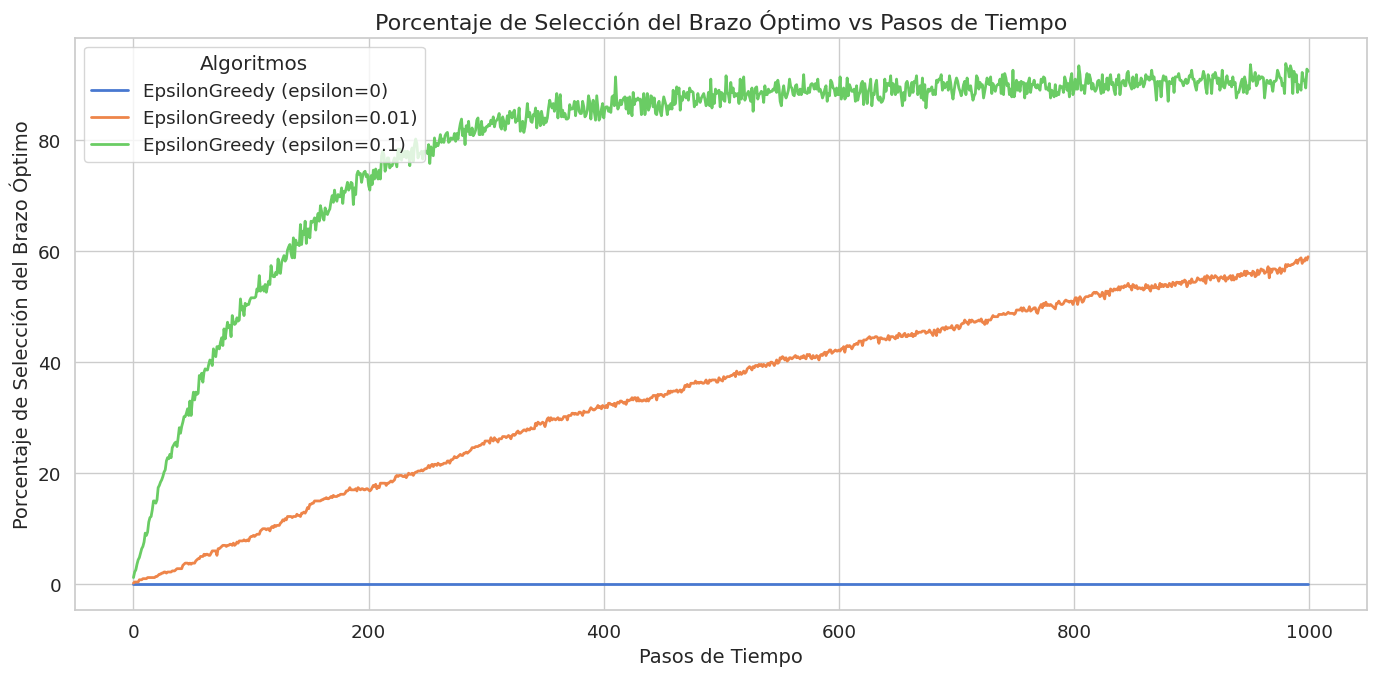

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

En el gráfico se muestra las veces que los diferentes algoritmos seleccionan los brazos óptimos.

* $\epsilon$ = 0: Recordemos que esta opción es completamente explotadora, lo que significa que nunca explora nuevas opciones solo elige la acción con la mejor recompensa observada hasta el momento. En este caso la línea se mantiene plana en 0%, indicando que nunca logra identificar el brazo óptimo.

* $\epsilon$ = 0.01: Estrategia 1% de exploración. Es decir, un 1% de elegir una acción aleatoria en cada paso. Se observa un crecimiento gradual, indicando que con el tiempo la estrategia logra seleccionar con mayor frecuencia el brazo óptimo, aunque de manera más lenta.

* $\epsilon$ = 0.1: Estrategia 10% de exploración. El aumento de porcentaje permite descubrir el brazo óptimo rápidamente. Se muestra un crecimiento rápido en los primeros pasos y alcanza más del 80% de selección del brazo óptimo, estabilizándose en un valor alto.

El uso de exploración en el algoritmo es fundamental para encontrar y seleccionar el brazo óptimo. Un valor de $\epsilon$ demasiado bajo puede hacer que no encontremos el brazo óptimo o ralentizar el aprendizaje, mientras que un valor alto acelera la identificación.

### Estadísticas de los brazos

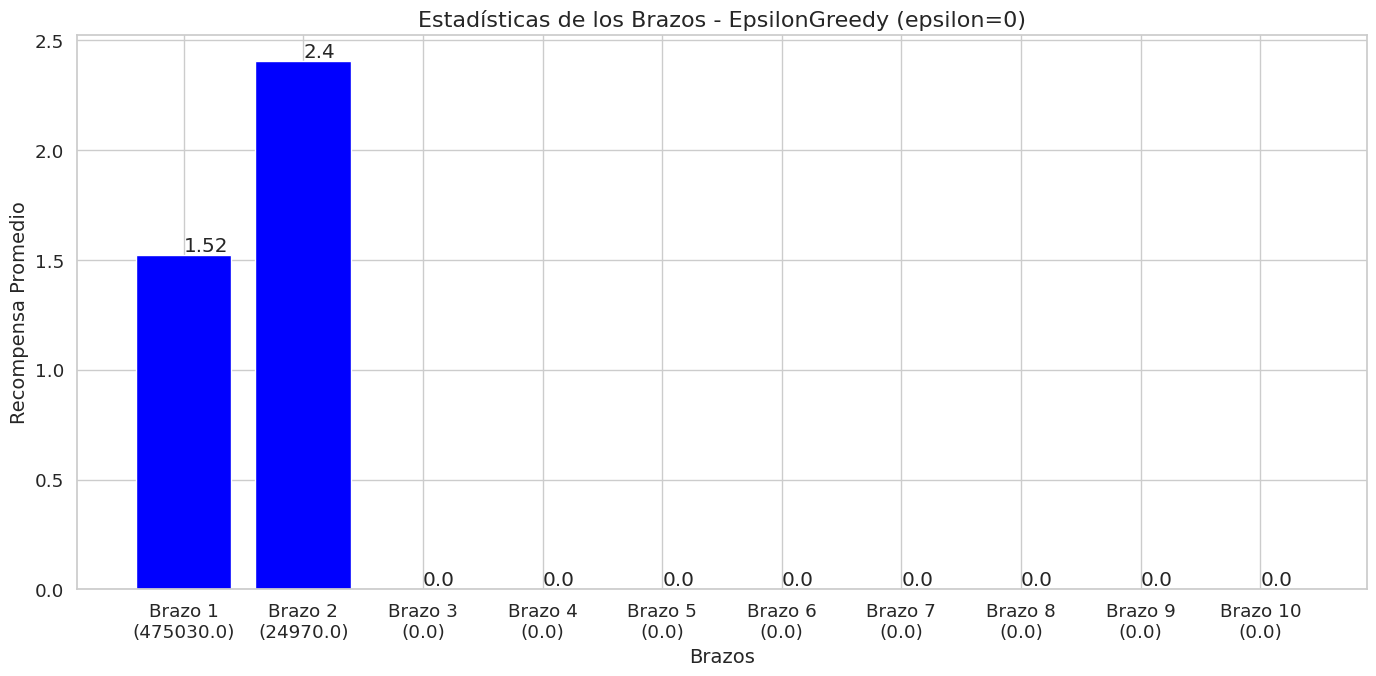

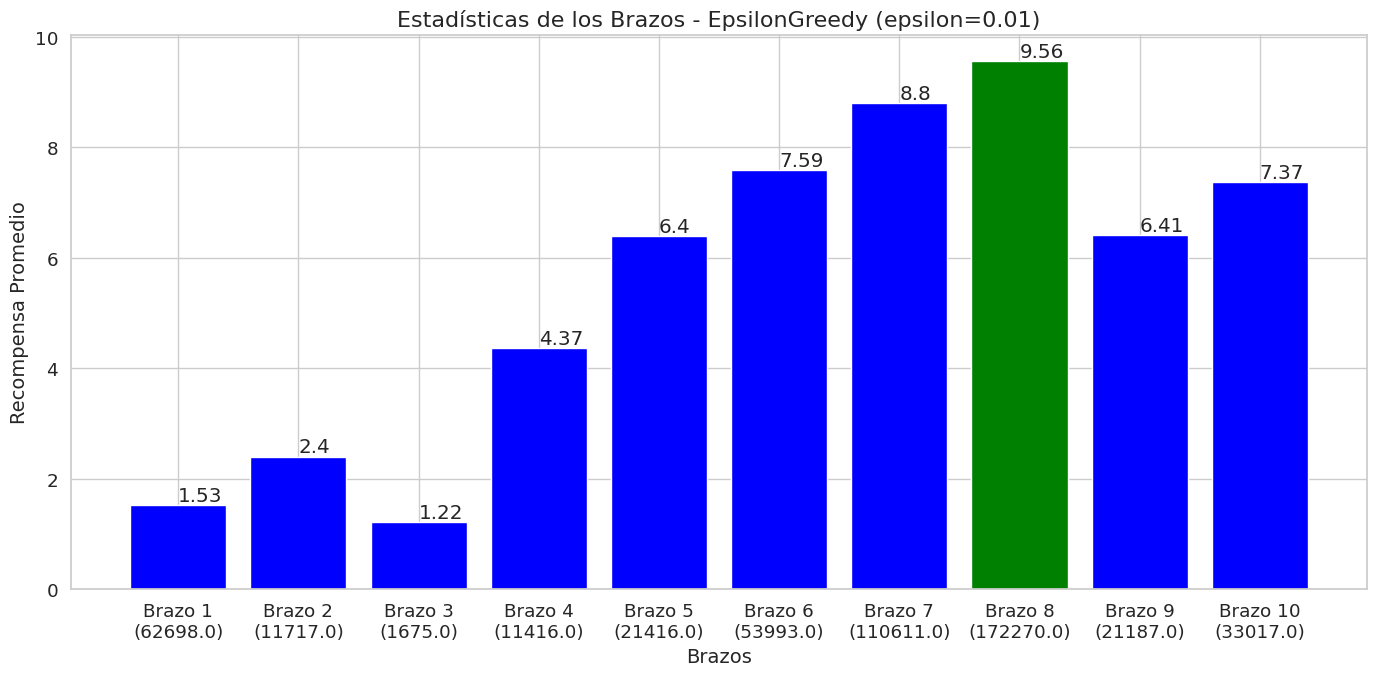

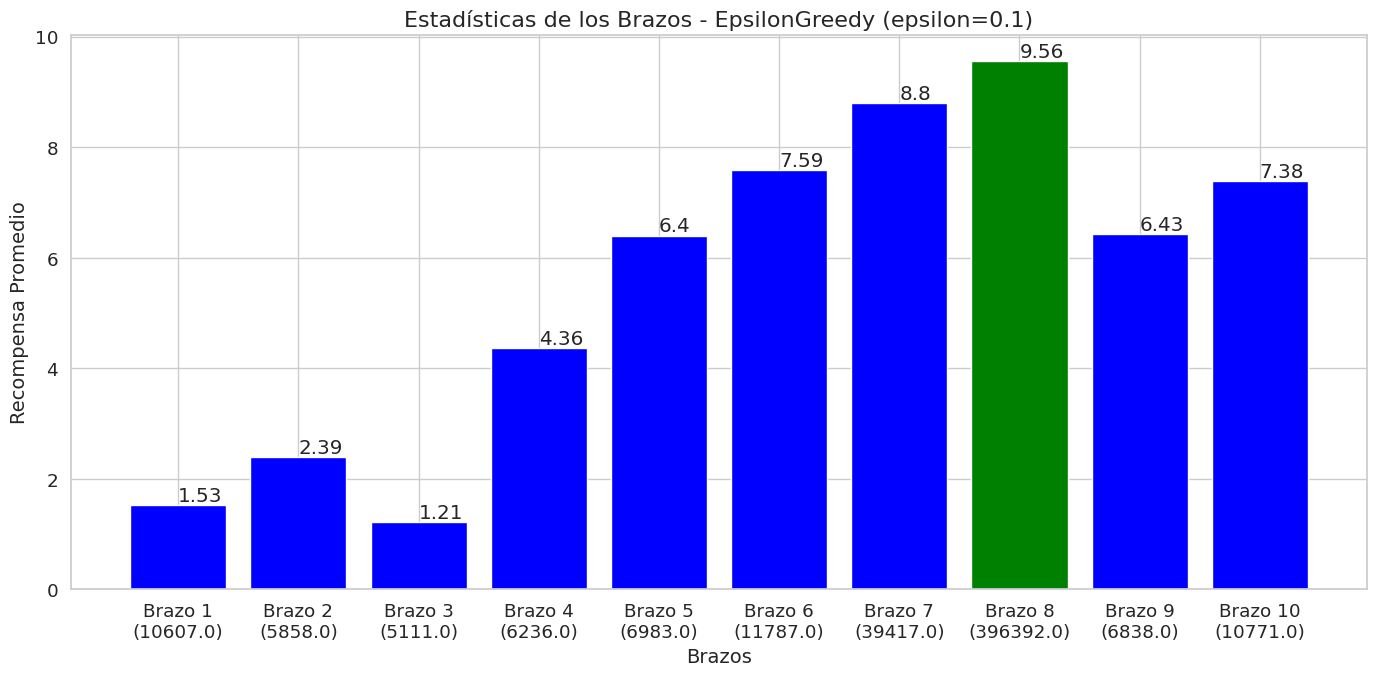

In [ ]:
plot_arm_statistics(k, arm_counts, arm_rewards, optimal_arm, algorithms)

En las tres gráficas anteriores se muestra la selección entre los distintos brazos y la recompensa promedio de cada uno.

* Primer gráfico $\epsilon$ = 0: Esta estrategia no explora y por ello elige la opción conocida desde el inicio. Las recompensas promedias son bastante bajas, 1.52 y 2.39.

* Segundo gráfico $\epsilon$ = 0.01: El algoritmo descubre y prueba todos los brazos, al menos 700 veces cada uno. El brazo 8 tiene la recompensas media más alta y ha sido el más seleccionado, seguido del brazo 7. Este algoritmo sí que logra encontrar el brazo óptimo pero no explotarlo.

* Tercer gráfico $\epsilon$ = 0.1: También encuentra el brazo 8 como el mejor, y, en esta ocasión, consigue explotarlo, utilizando más veces ese brazo.

## Relevancia gráficas

Cada una de las gráficas proporciona infromación clave sobre el algoritmo. Vamos a comenzar explicando para que utilizamos cada una de las gráficas. Y, despues, comentaremos cuales creemos nosotros que son mas relevantes.

**Recompensa Promedio vs Pasos de Tiempo**
* Indica si el algoritmo converge hacia un buen rendimiento y cuánto tarda en hacerlo.
* Nos permite comparar diferentes variantes y ver cuál logra la mejor recompensa.

**Regret Acumulado vs Pasos de Tiempo**
* Mide cuánto "pierde" el algoritmo por no haber elegido siempre el brazo óptimo.
* Permite detectar estrategias que convergen lentamente o no exploran lo suficiente.

**Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**
* Indica qué tan frecuentemente el algoritmo elige el mejor brazo.
* Permite evaluar la eficiencia del proceso de aprendizaje.

**Estadísticas de los Brazos**
* Permite ver cómo el algoritmo distribuye sus elecciones entre los diferentes brazos.
* Útil para entender por qué un algoritmo puede estar funcionando mal (por ejemplo, si está sobreexplotando un brazo subóptimo).

Creemos que las gráficas más relevantes son Recompensa Promedio, Regret Acumulado y Porcentaje de Selección del Brazo Óptimo porque juntas ofrecen una visión completa del rendimiento del algoritmo. La gráfica de estadísticas de los brazo es útil para diagnóstico, pero no es tan esencial como las otras tres para evaluar el rendimiento general del algoritmo.

## Conclusión

Los resultados obtenidos en el experimento muestran claramente la importancia de la exploración en el problema del bandido de los k-brazos. Un valor de ε demasiado bajo impide que el algoritmo descubra el brazo óptimo, lo que resulta en un alto regret acumulado y un desempeño pobre a lo largo del tiempo. En contraste, una estrategia con un nivel moderado de exploración (ε = 0.1) logra identificar rápidamente la mejor opción y estabilizarse en una alta recompensa esperada.

Un posible comportamiento extraño que podría surgir en este tipo de problemas es la selección temprana y errónea de un brazo subóptimo con una recompensa inicial alta debido a fluctuaciones estadísticas. Si el algoritmo tiene un ε demasiado bajo, puede quedar atrapado explotando un brazo que parece bueno al inicio pero que en realidad no es el óptimo. Por otro lado, si la varianza de las recompensas fuera mayor, el aprendizaje del algoritmo podría verse afectado, requiriendo una exploración aún más extensa para diferenciar correctamente entre los brazos.

# Comparación entre el número de brazos
Para comparar los algoritmos en escenarios con diferentes niveles de complejidad. Para ello en este apartado se estudiará como el número de brazos afecta en la capacidad de convergencia y la eficiencia de ambos algoritmos.

Los objetivos son:

* Determinar como el rendimiento de los algoritmos se ve afectado al aumentar el número de brazos.
* Observar como la velocidad de convergencia varía en función del número de brazos.

Se realizarán experimentos variando el número de brazos en el siguiente rango $[20, 30]$.

### K = 20


In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 20  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 20 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=2.91, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0), ArmNormal(mu=9.73, sigma=1.0), ArmNormal(mu=8.49, sigma=1.0), ArmNormal(mu=5.72, sigma=1.0), ArmNormal(mu=6.51, sigma=1.0), ArmNormal(mu=3.74, sigma=1.0), ArmNormal(mu=3.62, sigma=1.0), ArmNormal(mu=4.89, sigma=1.0), ArmNormal(mu=2.64, sigma=1.0), ArmNormal(mu=2.65, sigma=1.0)
Optimal arm: 12 with expected reward=9.73


#### Recompensa promedio

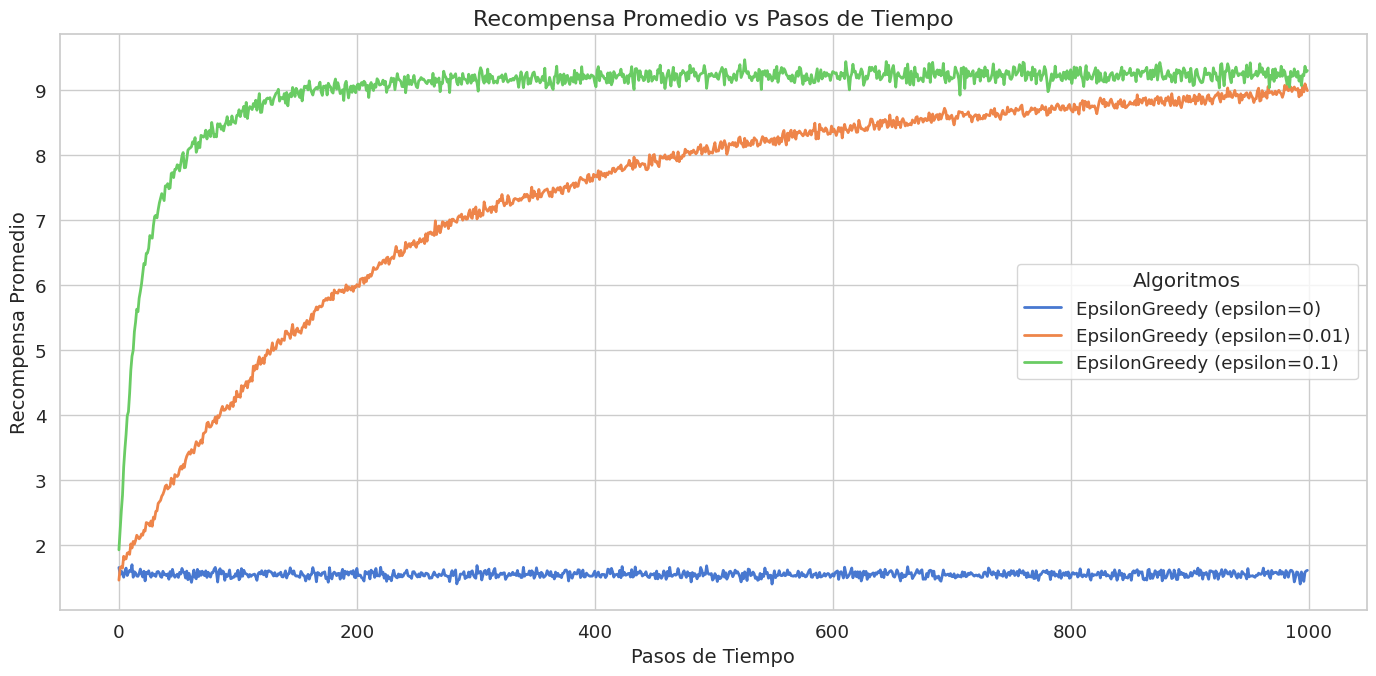

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes del algoritmo Epsilon-Greedy con diferentes valores de parámetros.

**Análisis del comportamiento**
* La variante con epsilon=0.01 tarda un poco más en converger.
* Ninguna variante llega a la recompensa esperada máxima. La variante con epsilon=0.1 se queda bastante cerca.

**Conclusiones**
  * Aumentar el número de brazos no parece que afecte mucho al rendimiento del algoritmo.
  * Aumenta ligeramente el número de pasos de tiempo necesarios para converger.

#### Regret acumulado

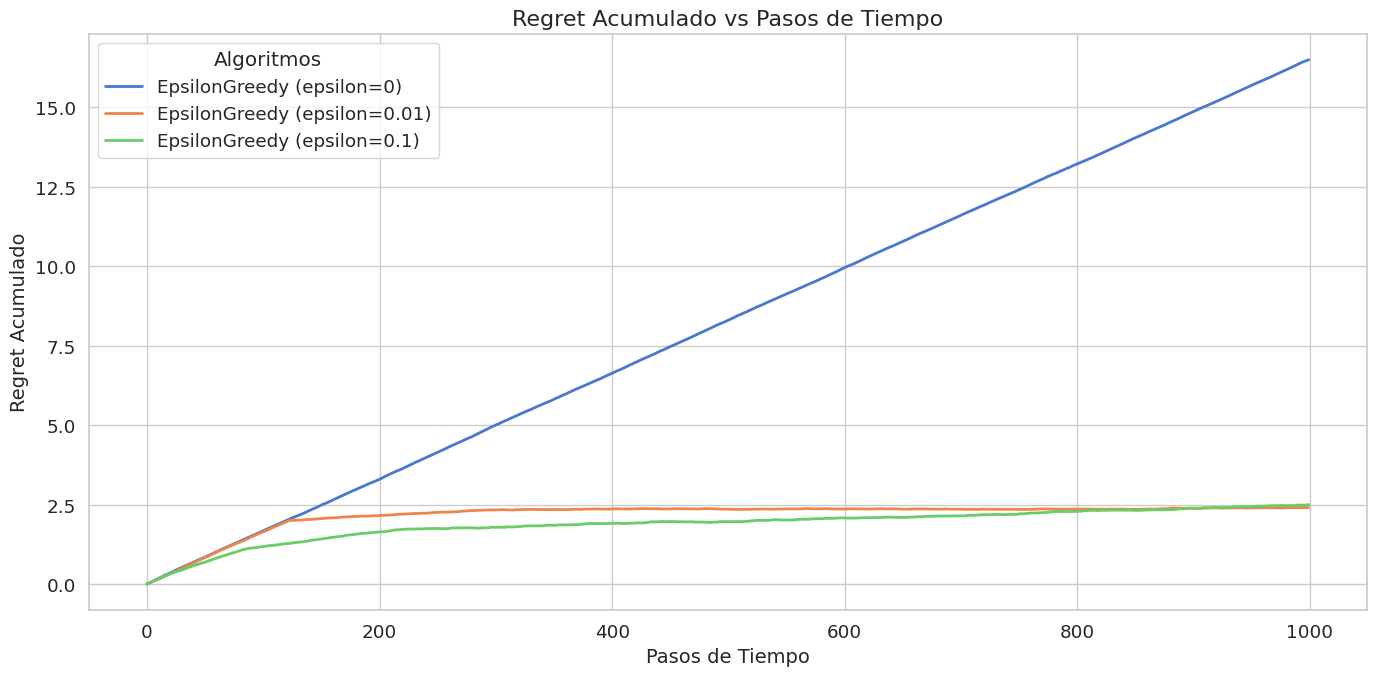

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes del algoritmo Epsilon-Greedy con diferentes valores de parámetros.

**Análisis del comportamiento**
* $\epsilon$ = 0: Estrategia completamente explotadora. Su regret va creciendo linealmente a lo largo de los pasos de tiempo. Es el algoritmo que peor resultados ofrece. Esto indica que no encuentra el mejor brazo y continúa seleccionando opciones que no son óptimas.

* $\epsilon$ = 0.01: Estrategia 1% de exploración. Valor de regret crece rápido al inicio, pero se estabiliza con el paso del tiempo. Esto indica que el algoritmo no encuentra al inicio las opciones óptimas, pero según pasa los pasos de tiempo va acercándose a la solución óptima.

* $\epsilon$ = 0.1: Estrategia 10% de exploración. Presenta el valor de regret es al inicio bastante bajo y se estabiliza temprano, indicando que la estrategia aprende rápidamente. Es la opción que menor regret acumula.

**Conclusiones**
  * Se puede observar una diferencia con el gráfico original en la variante con epsilon=0.1. Donde aquí el regret acumulado es bastante más alto.

#### Porcentaje de selección del brazo óptimo

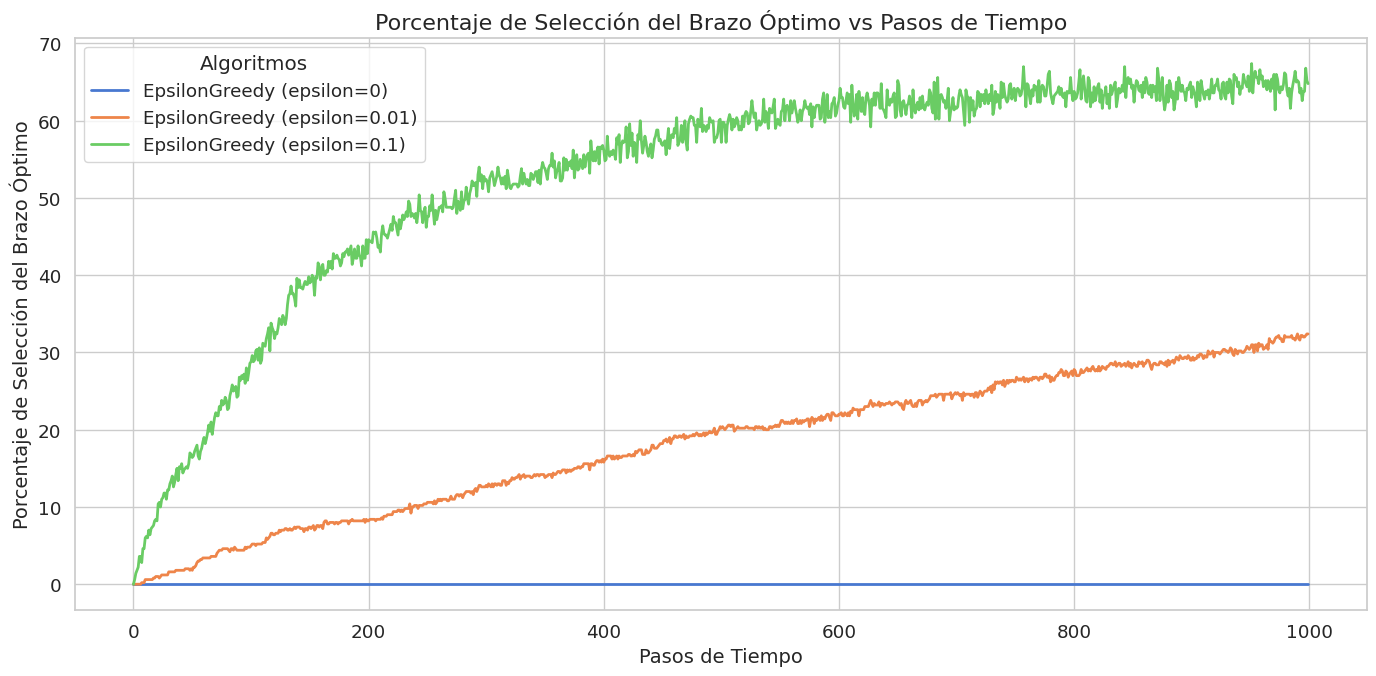

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintas variantes del algoritmo Epsilon-Greedy con diferentes valores de parámetros.

**Observaciones principales**
  * Un disminución general del porcentaje de selección del brazo óptimo.

**Conclusiones**
* Aumentar el número de brazos incrementa la dificultad del problema, con su consecuente pérdida en porcentaje de selección del brazo óptimo.

### K = 30

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 30  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 30 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=2.91, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0), ArmNormal(mu=9.73, sigma=1.0), ArmNormal(mu=8.49, sigma=1.0), ArmNormal(mu=5.72, sigma=1.0), ArmNormal(mu=6.51, sigma=1.0), ArmNormal(mu=3.74, sigma=1.0), ArmNormal(mu=2.26, sigma=1.0), ArmNormal(mu=5.1, sigma=1.0), ArmNormal(mu=6.33, sigma=1.0), ArmNormal(mu=8.07, sigma=1.0), ArmNormal(mu=2.8, sigma=1.0), ArmNormal(mu=3.62, sigma=1.0), ArmNormal(mu=3.63, sigma=1.0), ArmNormal(mu=4.89, sigma=1.0), ArmNormal(mu=4.3, sigma=1.0), ArmNormal(mu=5.63, sigma=1.0), ArmNormal(mu=6.47, sigma=1.0), ArmNormal(mu=2.64, sigma=1.0), ArmNormal(mu=2.65, sigma=1.0), ArmNormal(mu=1.42, sigma=1.0)
Optimal arm: 12 with expected reward=9.73


#### Recompensa promedio

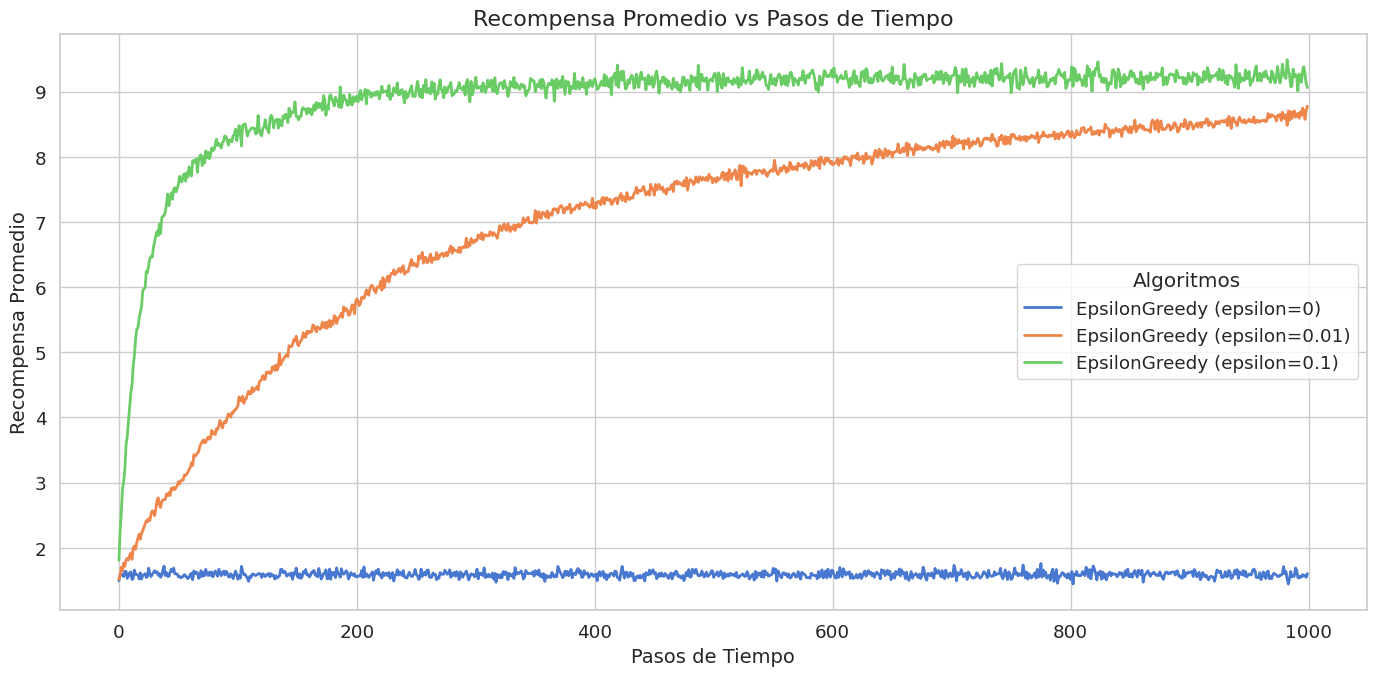

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes del algoritmo Epsilon-Greedy con diferentes valores de parámetros.

**Análisis del comportamiento**
* Tarda un poco más en converger.
* La recompensa promedio disminuye un poco.

**Conclusiones**
  * Aquí si hemos visto una disminución de la recompensa promedio, indicando que aumentar el número de brazos si que perjudica al algoritmo.
  * Aumenta ligeramente el número de pasos de tiempo necesarios para converger.

#### Regret acumulado

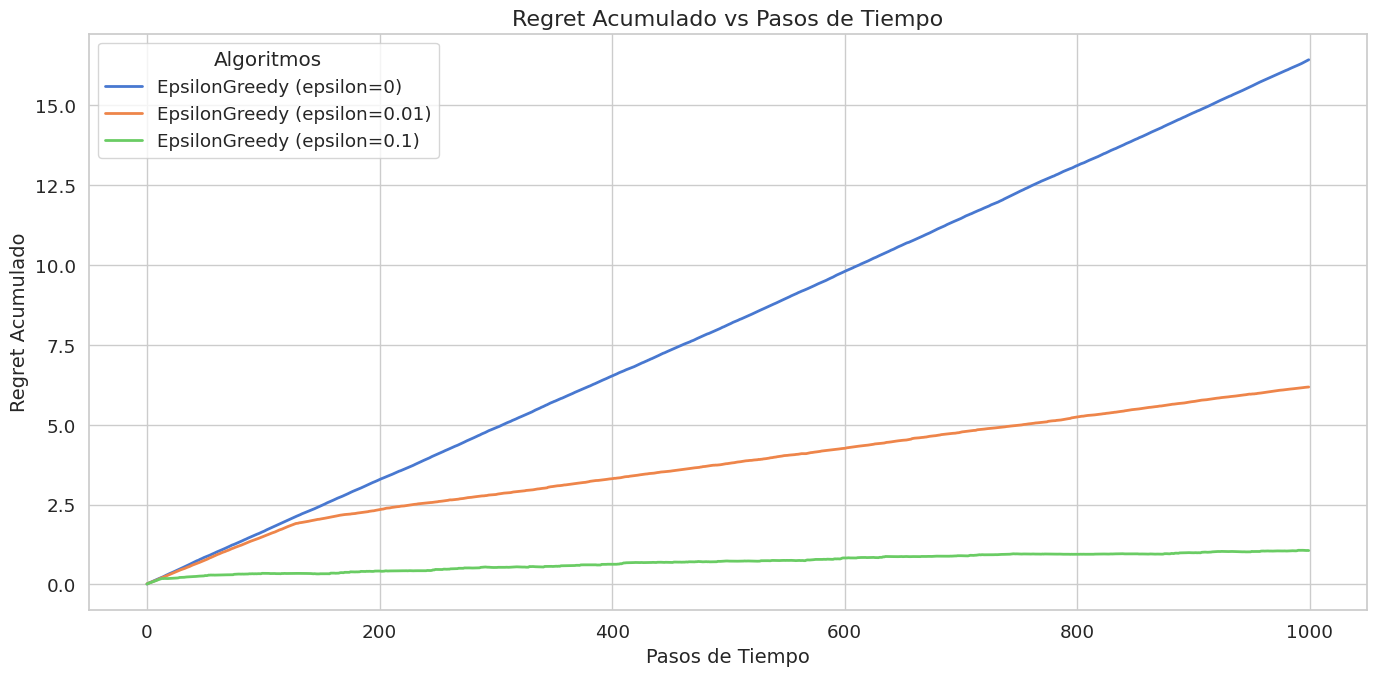

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes del algoritmo Epsilon-Greedy con diferentes valores de parámetros.

**Análisis del comportamiento**
* Vemos como la variante con epsilon=0.1 vuelve a obtener resultados muy buenos. Mejores que los obtenidos con 20 brazos.

**Conclusiones**
  * Los resultados son bastante parecedidos a los obtenidos con 10 brazos.

#### Porcentaje de selección del brazo óptimo

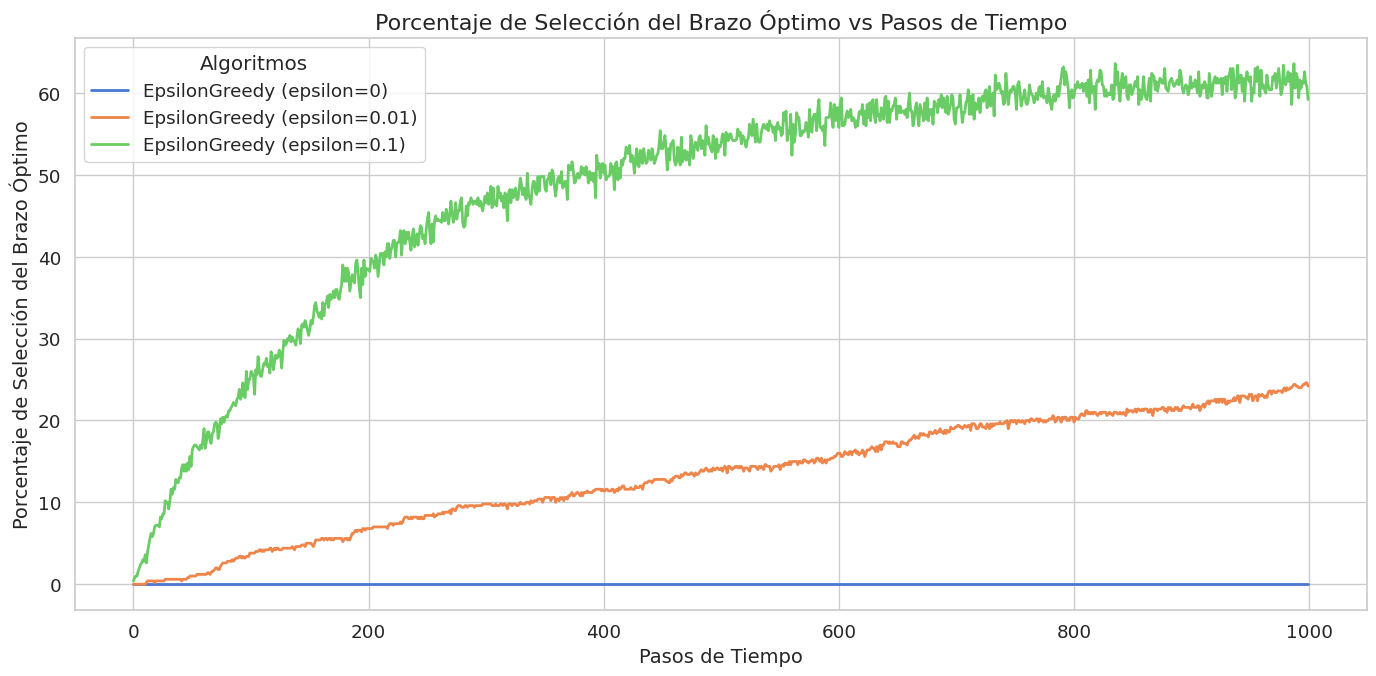

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintas variantes del algoritmo Epsilon-Greedy con diferentes valores de parámetros.

**Observaciones principales**
  * Ligera disminución del porcentaje de selección del brazo óptimo.
  * El cambio en los porcentajes es menor que el sufrido cuando aumentamos de 10 a 20 brazos.

**Conclusiones**
* Aumentar el número de brazos incrementa la dificultad del problema, con su consecuente pérdida en porcentaje de selección del brazo óptimo.

## Conclusión
Al aumentar el número de brazos en el problema del bandido, observamos ciertos patrones recurrentes en el desempeño del algoritmo Epsilon-Greedy. En general, incrementar la cantidad de opciones disponibles hace que la selección del brazo óptimo sea más difícil y retrasa la convergencia del algoritmo. Sin embargo, los efectos no son drásticos, y la estrategia con un valor moderado de exploración (ε = 0.1) sigue ofreciendo los mejores resultados en términos de regret y recompensa promedio.

Otro efecto notable es el aumento en el regret acumulado cuando se incrementa el número de brazos. Con más opciones disponibles, es más probable que el algoritmo seleccione acciones subóptimas antes de converger al mejor brazo. Esto es especialmente evidente con ε = 0.01, donde la exploración limitada hace que el regret inicial crezca más rápido.

En conclusión, aunque aumentar el número de brazos dificulta el problema y afecta ligeramente la recompensa promedio y el regret acumulado, el algoritmo sigue funcionando de manera similar, con una estrategia de exploración moderada siendo la opción más efectiva.

# Comparación entre distribuciones
El paso final es analizar su comportamiento ante diferentes distribuciones de recompensa.

No se va a analizar la distribución normal ya que saldrían las mismas graficas que obtenidas en el apartado "Análisis individual".

## Distribución binomial


In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k, 10)) # Generar un bandido con k brazos de distribución binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBinomial(n=10, p=0.4), ArmBinomial(n=10, p=0.86), ArmBinomial(n=10, p=0.22), ArmBinomial(n=10, p=0.69), ArmBinomial(n=10, p=0.58), ArmBinomial(n=10, p=0.15), ArmBinomial(n=10, p=0.79), ArmBinomial(n=10, p=0.67), ArmBinomial(n=10, p=0.12), ArmBinomial(n=10, p=0.88)
Optimal arm: 10 with expected reward=8.8


### Recompensa promedio

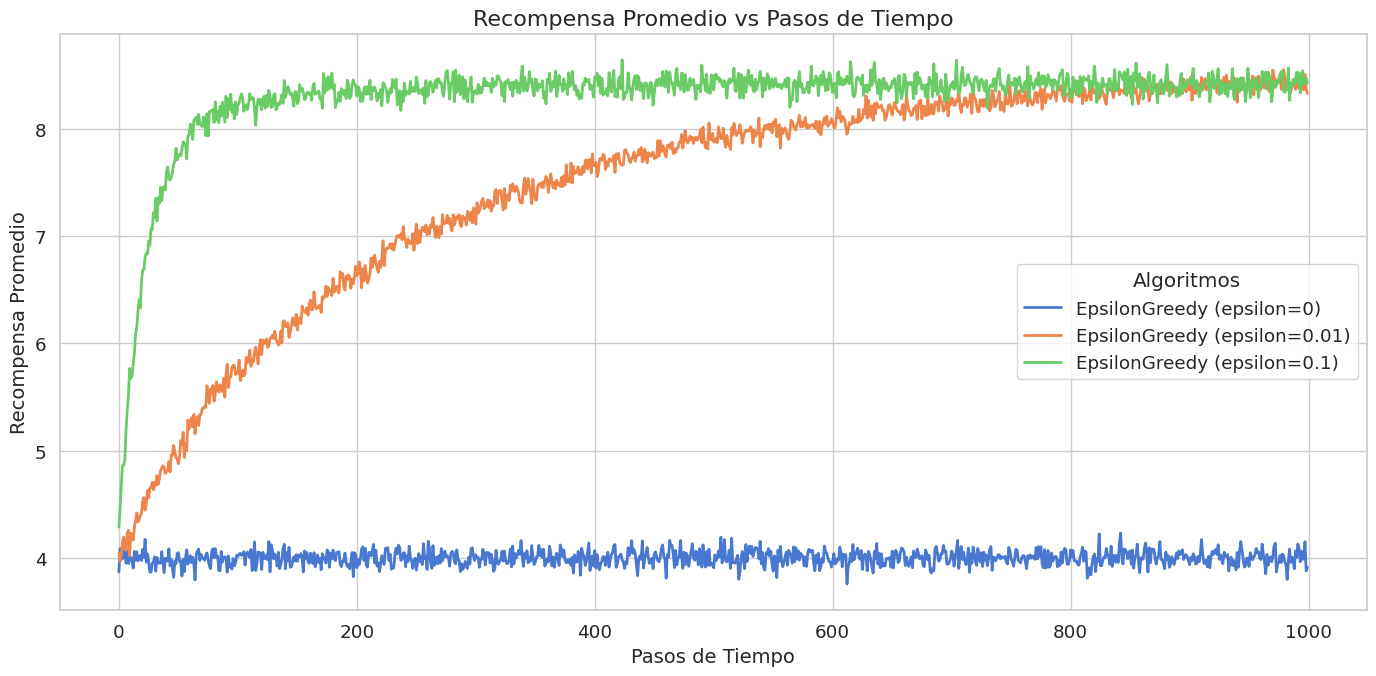

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes del algoritmo Epsilon-Greedy con diferentes valores de parámetros.

**Análisis del comportamiento**
* Igual que con la distribución normal.
* Aumenta la variabilidad.
* La variante con epsilon=0.01 llega a la misma recompensa promedio que la variante con epsilon=0.1. Eso no pasa en la distribución normal.

**Conclusiones**
  * Resultados muy similares con la distribución normal.

### Regret Acumulado

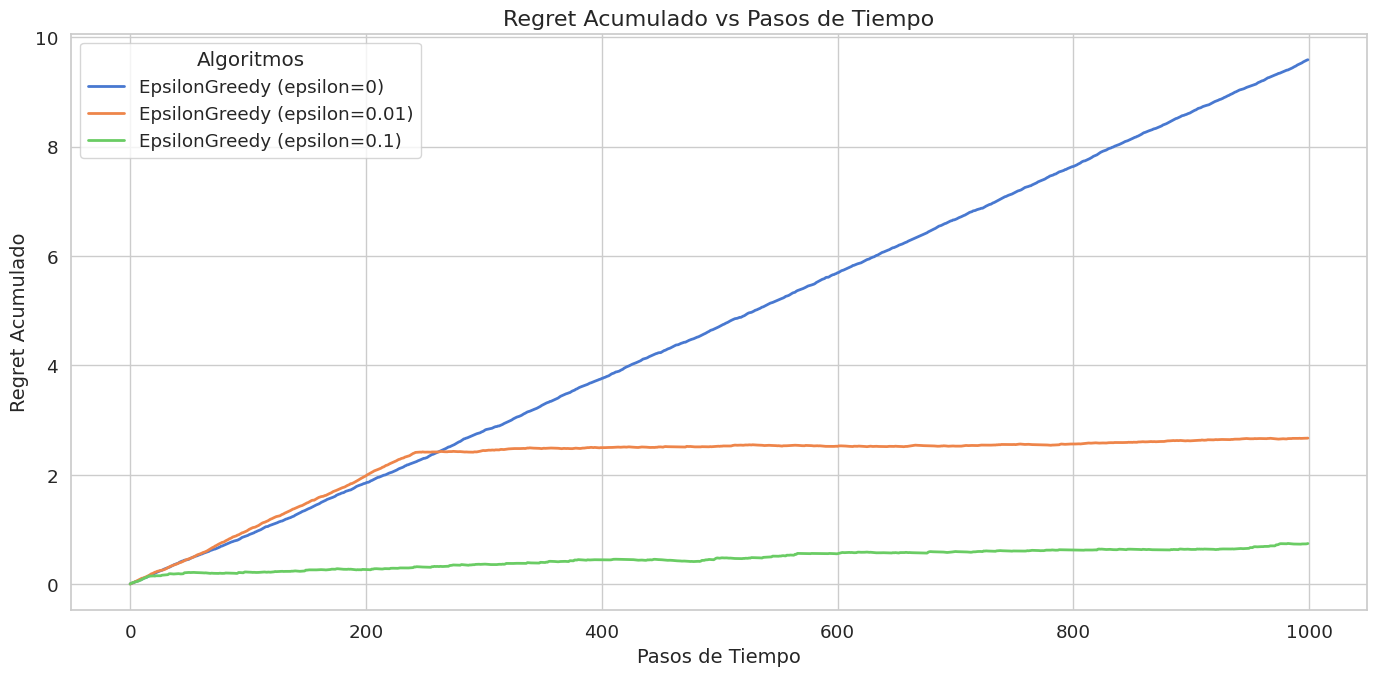

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes del algoritmo Epsilon-Greedy con diferentes valores de parámetros.

**Análisis del comportamiento**

* Para la variante  con epsilon=0.01, el regret aumenta linealmente durante más pasos de tiempo al inicio.

**Conclusiones**
  * Se puede observar una diferencia con el gráfico original en la variante con epsilon=0.1. Donde aquí el regret acumulado es bastante más alto.

### Porcentaje de selección del brazo óptimo

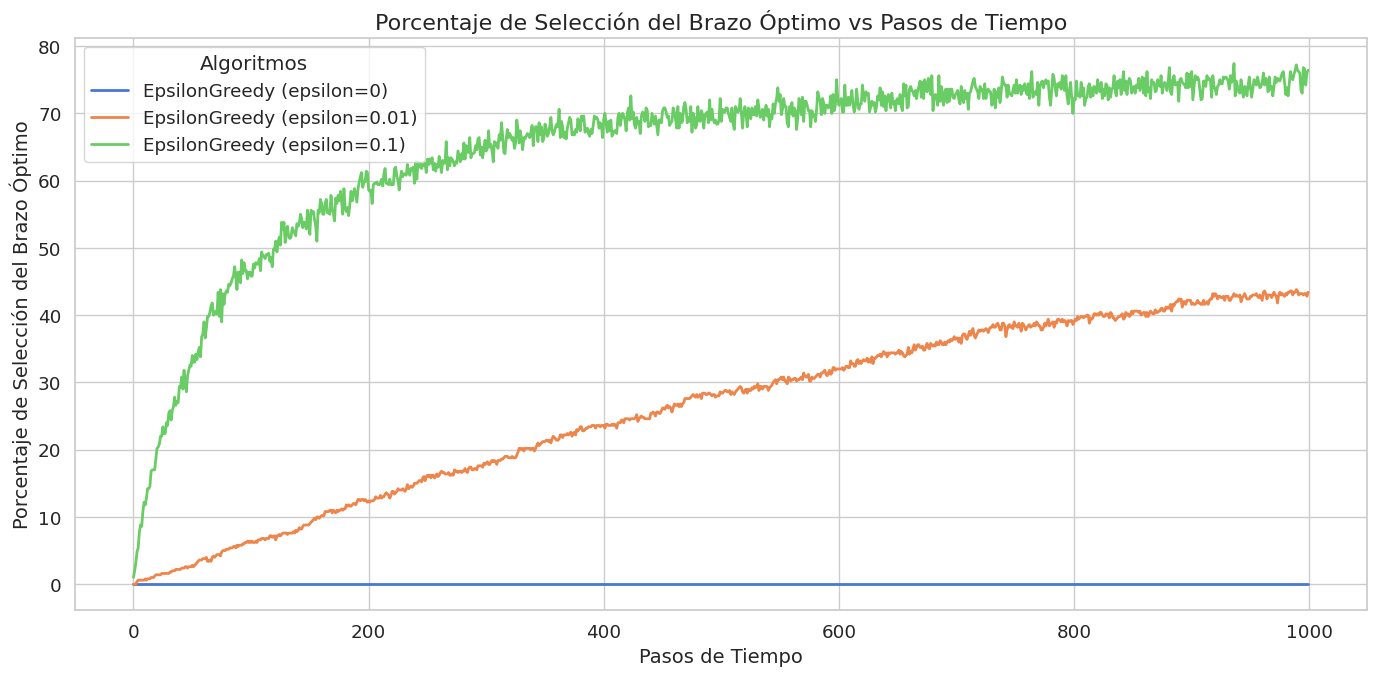

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintas variantes del algoritmo Epsilon-Greedy con diferentes valores de parámetros.

**Observaciones principales**
  * Un disminución general del porcentaje de selección del brazo óptimo.
  * Tarda más en converger.

**Conclusiones**
* Parece que cuesta más encontrar el brazo óptimo que con la distribución normal.

### Conclusión
Al cambiar la distribución de las recompensas de normal a binomial, observamos un comportamiento similar al caso anterior, pero con algunas diferencias clave. La principal es que la variabilidad de las recompensas aumenta, lo que afecta la rapidez con la que el algoritmo puede identificar el mejor brazo. En particular, la variante con ε = 0.01 logra alcanzar una recompensa promedio similar a la de ε = 0.1, lo que no sucedía con la distribución normal. Esto sugiere que, en este escenario, una menor tasa de exploración sigue siendo suficiente para encontrar el brazo óptimo, aunque con mayor incertidumbre inicial.

La naturaleza discreta de la distribución binomial también influye en el regret acumulado. En este caso, el regret de ε = 0.1 es más alto que en la distribución normal, lo que indica que el algoritmo tarda más en diferenciar los brazos buenos de los malos.

La distribución binomial no necesariamente perjudica al algoritmo, pero sí cambia la dinámica del aprendizaje. En la distribución normal, la varianza es constante, mientras que en la binomial depende del valor de p. Esto significa que algunos brazos tendrán mayor variabilidad que otros, lo que puede confundir al algoritmo en los primeros pasos, ya que podría percibir un brazo subóptimo como mejor debido a una fluctuación estadística.

## Distribución de Bernoulli

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución Bernoulli
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBernoulli(p=0.4), ArmBernoulli(p=0.86), ArmBernoulli(p=0.22), ArmBernoulli(p=0.69), ArmBernoulli(p=0.58), ArmBernoulli(p=0.15), ArmBernoulli(p=0.79), ArmBernoulli(p=0.67), ArmBernoulli(p=0.12), ArmBernoulli(p=0.88)
Optimal arm: 10 with expected reward=0.88


### Recompensa promedio

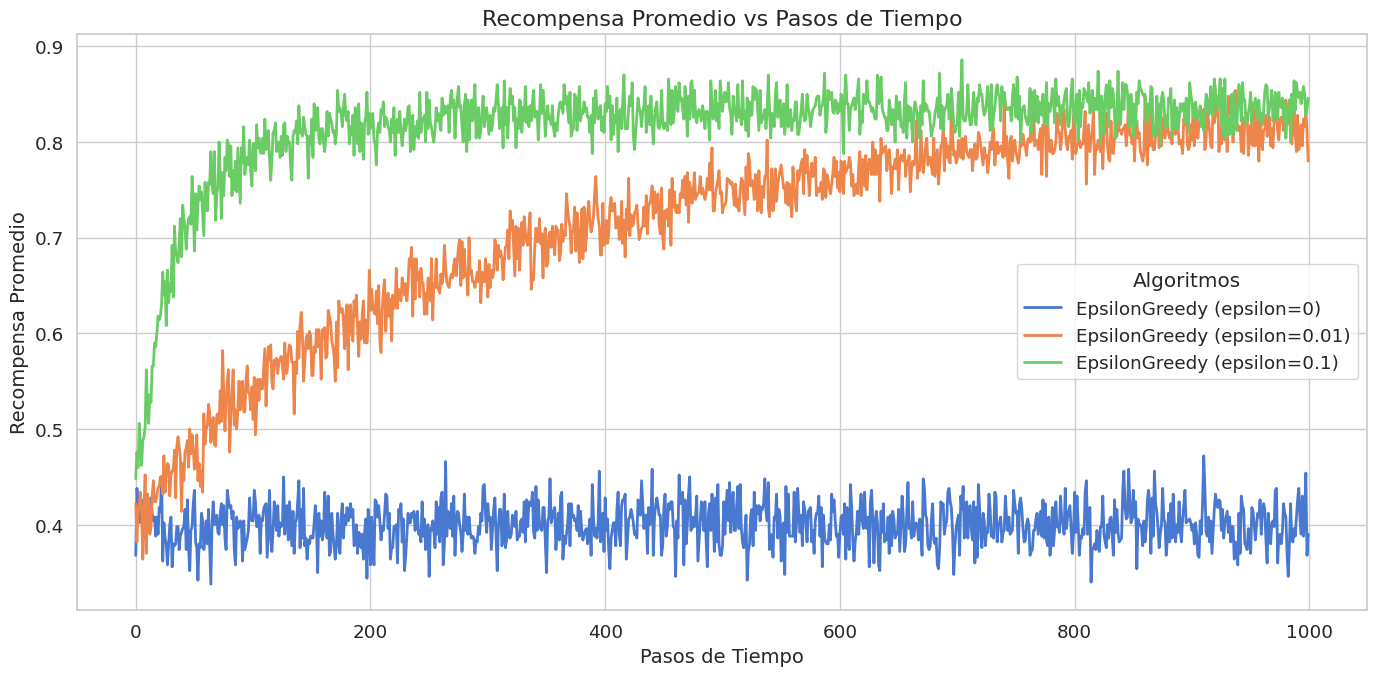

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes del algoritmo Epsilon-Greedy con diferentes valores de parámetros.

**Análisis del comportamiento**
*  Mucha más variabilidad.
* La variante con epsilon=0.01 ya no llega a la misma recompensa promedio que la variante con epsilon=0.1. Igual que en la normal, se queda ligeramente por debajo.

**Conclusiones**
  * Resultados muy similares a las otras distribuciones.

### Regret acumulado

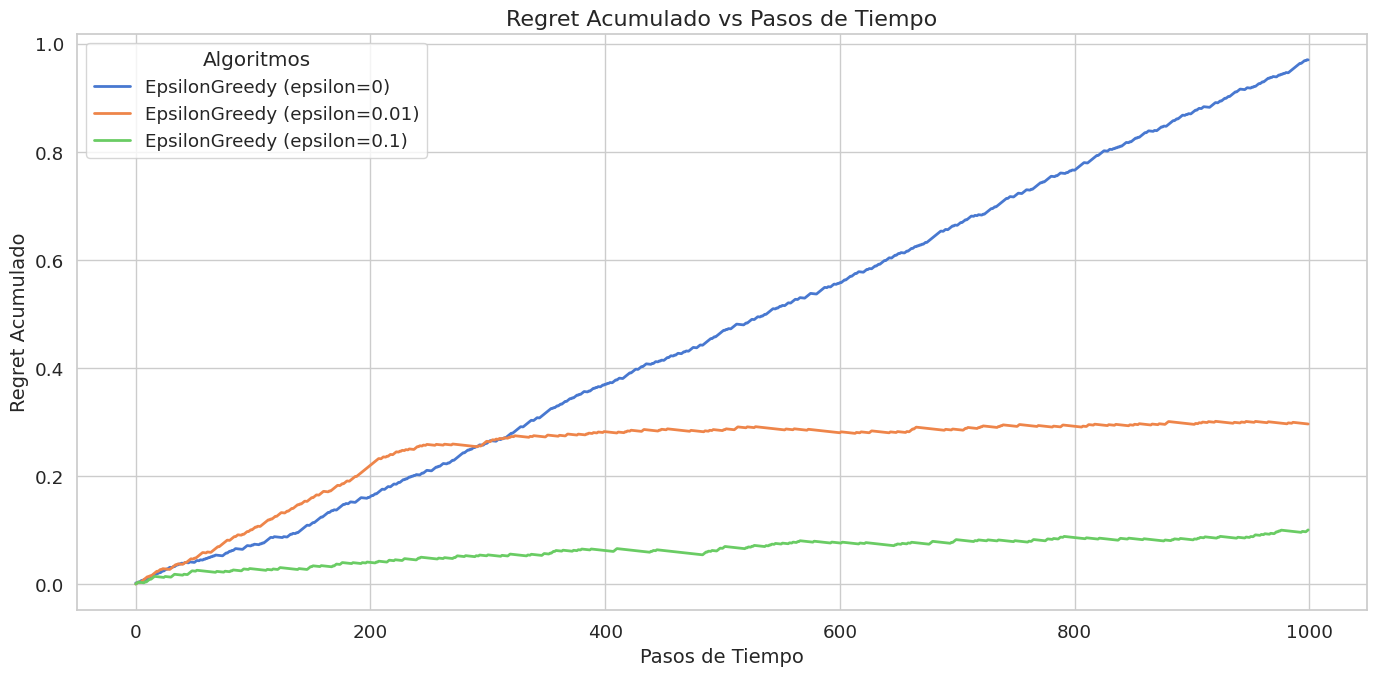

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes del algoritmo Epsilon-Greedy con diferentes valores de parámetros.

**Análisis del comportamiento**

* Para la variante  con epsilon=0.01, el regret aumenta linealmente durante más pasos de tiempo al inicio.
* Lo mismo pasaba con la distribución binomial.

**Conclusiones**
  * Resultado bastante parecido al obtenido en la distribución binomial.

### Porcentaje de selección del brazo óptimo

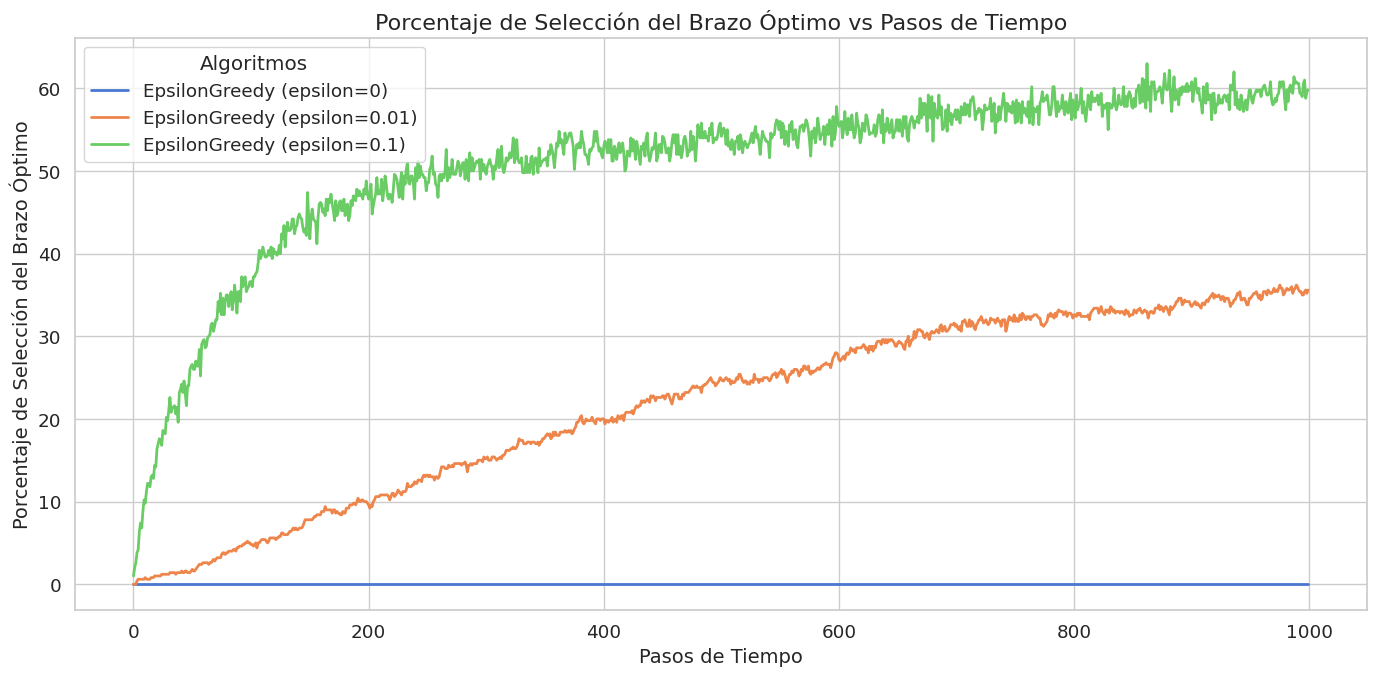

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintas variantes del algoritmo Epsilon-Greedy con diferentes valores de parámetros.

**Observaciones principales**
  * Un disminución general del porcentaje de selección del brazo óptimo.
  * Tarda más en converger.

**Conclusiones**
* Parece que cuesta más encontrar el brazo óptimo que con la distribución normal y binomial.

### Conclusión
Al emplear una distribución de Bernoulli en lugar de una normal o binomial, observamos un impacto notable en el rendimiento del algoritmo. En particular, la variabilidad en las recompensas es aún mayor, ya que cada brazo devuelve únicamente valores de 0 o 1, lo que significa que el algoritmo depende completamente de la frecuencia con la que se obtienen recompensas exitosas. Esto introduce más ruido en la evaluación de cada brazo y dificulta la identificación del óptimo.

El regret acumulado sigue el mismo patrón que en la distribución binomial: cuando ϵ = 0.01, el regret crece linealmente durante más tiempo antes de estabilizarse, lo que sugiere que el algoritmo tarda más en diferenciar los brazos buenos de los malos. Sin embargo, en comparación con las otras distribuciones, aquí la convergencia es aún más lenta, lo que indica que la exploración inicial es aún más importante.

El porcentaje de selección del brazo óptimo también sufre una disminución general y la convergencia es más lenta que en los otros casos. Esto se debe a que la distribución Bernoulli introduce una mayor incertidumbre en la estimación de la recompensa esperada de cada brazo.

## Conclusiones finales

A lo largo del experimento, probamos el algoritmo Epsilon-Greedy con diferentes configuraciones de número de brazos y distribuciones de recompensa. A partir de los resultados obtenidos, podemos extraer varias conclusiones clave sobre cómo estas variables afectan el rendimiento del algoritmo.

1. **Impacto del Número de Brazos**

  Aumentar el número de brazos incrementa la dificultad del problema por varias razones:
  * Mayor exploración requerida.
  * Menor porcentaje de selección del brazo óptimo.
  * Regret más alto al inicio.

  Sin embargo, observamos que el rendimiento final del algoritmo no se ve drásticamente afectado al pasar de 10 a 20 o 30 brazos, aunque sí aumenta el tiempo necesario para converger.

2. **Impacto de la distribución de Recompensas**

  La distribución de recompensas afecta cómo el algoritmo aprende y selecciona el mejor brazo.
  
  **Distribución Normal**
  * Resultados más estables: La distribución normal genera valores continuos con menor variabilidad, lo que permite una estimación más precisa de la recompensa esperada de cada brazo.
  * Rápida convergencia: Como los valores son más consistentes, el algoritmo encuentra el mejor brazo más rápido.

  **Distribucion Binomial**
  * Mayor variabilidad: Aunque los valores siguen una estructura predecible, la naturaleza discreta de la binomial introduce más incertidumbre que la normal.
  * Más exploración necesaria: el algoritmo tarda más en diferenciar los brazos buenos de los malos.
  * Resultados similares a la normal: A pesar de la mayor variabilidad, la recompensa promedio final es comparable a la obtenida con la distribución normal.

  **Distribución Bernoulli**
  * Mayor ruido en las estimaciones: Como solo hay dos posibles valores (0 o 1), la varianza es muy alta y el algoritmo necesita más pasos para estimar correctamente la recompensa esperada de cada brazo.
  * Convergencia más lenta: El porcentaje de selección del brazo óptimo es más bajo y el regret acumulado es más alto en comparación con las otras distribuciones.